In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


2025-06-23 06:57:09.407362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750661829.681020      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750661829.764351      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def extract_emotion_features(filename, fixed_length=130):
    y, sr = librosa.load(filename, duration=4, offset=0)
    # MFCC + Delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc = librosa.util.fix_length(mfcc, size=fixed_length, axis=1)

    delta = librosa.feature.delta(mfcc)
    delta = librosa.util.fix_length(delta, size=fixed_length, axis=1)

    delta2 = librosa.feature.delta(mfcc, order=2)
    delta2 = librosa.util.fix_length(delta2, size=fixed_length, axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = librosa.util.fix_length(chroma, size=fixed_length, axis=1)

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = librosa.util.fix_length(contrast, size=fixed_length, axis=1)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr = librosa.util.fix_length(zcr, size=fixed_length, axis=1)

    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth = librosa.util.fix_length(bandwidth, size=fixed_length, axis=1)

    # Pitch using librosa's piptrack
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_track = np.mean(pitches, axis=0)
    pitch_track = librosa.util.fix_length(pitch_track, size=fixed_length)
    pitch_feature = np.expand_dims(pitch_track, axis=0)


    # RMS energy
    rms = librosa.feature.rms(y=y)
    rms = librosa.util.fix_length(rms, size=fixed_length, axis=1)

    # Concatenate all features
    combined = np.concatenate((mfcc, delta,delta2, chroma, contrast, zcr, bandwidth, pitch_feature,rms), axis=0)

    return combined.T  # Shape: (time_steps, features)

In [3]:
def extract_label_from_filename(filename):
    modality=int(filename.split('-')[1])
    emotion_code = int(filename.split('-')[2])
    emotion_map = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
    }
    emotion=emotion_map.get(emotion_code)
    #return f"{modality}_{emotion}"
    return emotion

# Load file paths and labels
file_paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.wav'):
            label = extract_label_from_filename(filename)
            if label:
                path = os.path.join(dirname, filename)
                file_paths.append(path)
                labels.append(label)

df = pd.DataFrame({'audio': file_paths, 'label': labels})
print(len(file_paths))

4904


In [4]:
X_features = [extract_emotion_features(f) for f in df['audio']]
X = np.array(X_features)
print(X.shape)

(4904, 130, 62)


In [5]:


# Encode labels to integers
le = LabelEncoder()
y= le.fit_transform(df['label'])  # Integer labels for class_weight



# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)
# One-hot encode for model training
y = to_categorical(y)
print(le.classes_)

{0: 0.8151595744680851, 1: 0.8151595744680851, 2: 1.5963541666666667, 3: 0.8151595744680851, 4: 0.8151595744680851, 5: 1.6303191489361701, 6: 0.8151595744680851, 7: 1.5963541666666667}
['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [7]:
from sklearn.preprocessing import StandardScaler
import joblib

def normalize_train_val(X_train, X_val):
    # Flatten to 2D for scaler
    num_train, t, f = X_train.shape
    num_val = X_val.shape[0]

    X_train_flat = X_train.reshape(-1, f)
    X_val_flat = X_val.reshape(-1, f)

    # Fit scaler only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_val_scaled = scaler.transform(X_val_flat)

    # Save the scaler
    joblib.dump(scaler, 'scaler.pkl')

    # Reshape back to original 3D shapes
    X_train_scaled = X_train_scaled.reshape(num_train, t, f)
    X_val_scaled = X_val_scaled.reshape(num_val, t, f)

    return X_train_scaled, X_val_scaled


In [8]:
X_train, X_val = normalize_train_val(X_train, X_val)
print(X_train.shape, X_val.shape)


(3923, 130, 62) (981, 130, 62)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='checkpoints/epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_freq='epoch'
)
model = Sequential([
    
    
    Conv1D(64, 3, padding='same', activation='relu', input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=False)),
    BatchNormalization(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32,callbacks=[checkpoint_cb])#,class_weight=class_weights)removed due to no improvement

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750662226.772045      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/200


I0000 00:00:1750662237.267954      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.1874 - loss: 3.2301 - val_accuracy: 0.3170 - val_loss: 2.3402
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3443 - loss: 2.4805 - val_accuracy: 0.4638 - val_loss: 1.9253
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4222 - loss: 2.1275 - val_accuracy: 0.5831 - val_loss: 1.6729
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4960 - loss: 1.9071 - val_accuracy: 0.6463 - val_loss: 1.5080
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5887 - loss: 1.6503 - val_accuracy: 0.6758 - val_loss: 1.3991
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6743 - loss: 1.4492 - val_accuracy: 0.6983 - val_loss: 1.4219
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7098 - loss: 1.3057 - val_accuracy: 0.7564 - val_loss: 1.2198
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7540 - loss: 1.1849 - val_accurac

In [10]:
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss=np.array(history.history['loss'])
val_loss=np.array(history.history['val_loss'])
avg_loss=(loss+val_loss)/2
avg_acc = (train_acc + val_acc) / 2
best_epoch = np.argmax(avg_acc) + 1  # +1 because epochs start from 1 in filenames

print(f"Best average (acc + val_acc)/2 at epoch {best_epoch},accuracy={train_acc[best_epoch-1]}, validation accuracy={val_acc[best_epoch-1]}, average value = {avg_acc[best_epoch-1]:.4f}")
history.model.load_weights(f"checkpoints/epoch_{best_epoch:02d}.weights.h5")
model.save("kaggle/working/model.h5")

Best average (acc + val_acc)/2 at epoch 196,accuracy=0.9900586009025574, validation accuracy=0.9673802256584167, average value = 0.9787


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

       angry       1.00      0.99      0.99       150
        calm       0.94      0.96      0.95       151
     disgust       1.00      1.00      1.00        77
     fearful       0.94      0.97      0.95       150
       happy       0.98      0.97      0.98       150
     neutral       0.97      0.97      0.97        75
         sad       0.95      0.93      0.94       151
   surprised       1.00      0.95      0.97        77

    accuracy                           0.97       981
   macro avg       0.97      0.97      0.97       981
weighted avg       0.97      0.97      0.97       981



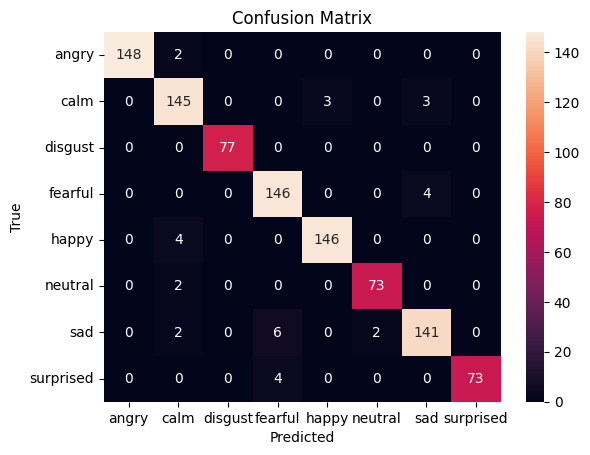

In [11]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
target_names = le.classes_


# Classification report
report =classification_report(y_true, y_pred_labels, target_names=target_names)
print(report)
with open("kaggle/working/classification_report.txt", "w") as f:
    f.write(report)
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("kaggle/working/confusion_matrix.png", dpi=300) 
plt.show()



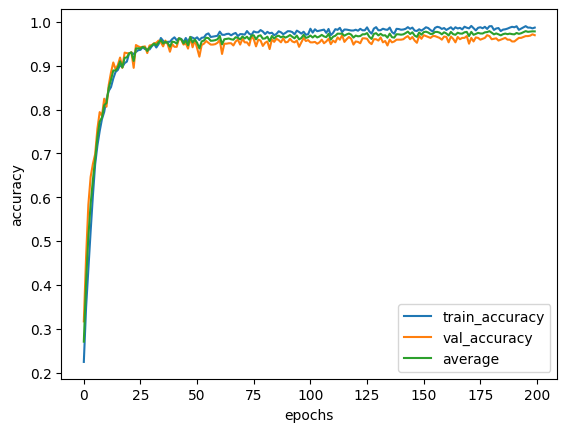

In [12]:


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))
plt.plot(epochs,acc,label='train_accuracy')
plt.plot(epochs,val_acc,label='val_accuracy')
plt.plot(epochs,avg_acc,label='average')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()



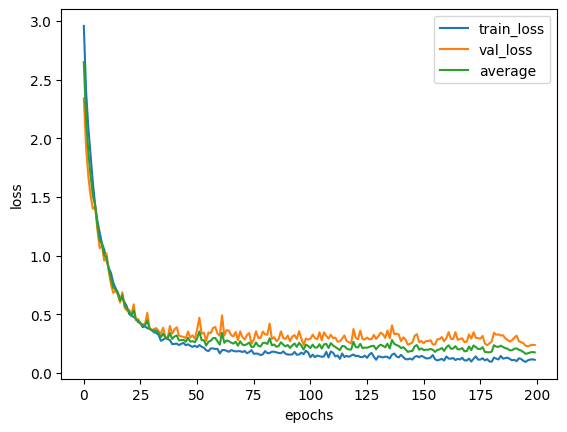

In [13]:


loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,label='train_loss')
plt.plot(epochs,val_loss,label='val_loss')
plt.plot(epochs,avg_loss,label='average')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

